In [12]:
# MINIMALLY, NEED PARQUETS TO RUN FROM "START HERE" CELL
# RUN ONLY THIS CELL IF HAVE PARQUETS AND NOT GENERATING PARQUETS FROM SCRATCH
import pandas as pd
import sqlite3
import math
import matplotlib.pyplot as plt
import os

# uses positioning information from GeoNames (https://www.geonames.org) to find landfall country/state from coordinates
# GeoNames database from https://download.geonames.org/export/dump/
# need US, Mexico, and Canada to differentiate landfalls that are close
geonames_dbs_txt = ['US/US.txt', 'MX/MX.txt', 'CA/CA.txt']
# this will be created in the cell below
geonames_db_sqlite = 'USMXCA.sqlite'

# best track data from https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/
best_tracks_na_csv = 'ibtracs.NA.list.v04r00.csv'
best_tracks_ep_csv = 'ibtracs.EP.list.v04r00.csv'

# Constants for Earth's radius in kilometers
EARTH_RADIUS_KM = 6371.0

# for calculating probabilities
default_start_year = 1851
default_end_year = 2002

# Function to calculate the Haversine distance between two coordinates
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = EARTH_RADIUS_KM * c

    return distance


def find_nearest_country_and_state(conn, lat, lon):
    cursor = conn.cursor()
    
    # Query the database to find the nearest place based on coordinates
    cursor.execute("""
        SELECT country, state, latitude, longitude FROM geonames
        WHERE latitude BETWEEN ? AND ?
        AND longitude BETWEEN ? AND ?
        ORDER BY ((latitude - ?) * (latitude - ?) + (longitude - ?) * (longitude - ?))
        LIMIT 1
    """, (lat - 1, lat + 1, lon - 1, lon + 1, lat, lat, lon, lon))

    result = cursor.fetchone()
    cursor.close()

    if result:
        country, state, place_lat, place_lon = result
        if str(state) != '00':
            distance = haversine_distance(lat, lon, place_lat, place_lon)
            return country, state, distance

    return None, None, None

# create a new empty dataframe with same template
def copy_df_structure(df_reference):
    new_df = df_reference.copy(deep=False)
    new_df.astype(df_reference.dtypes.to_dict())
    new_df = new_df[0:0]
    return new_df

# add landfall state for all US tropical storms and subtropical storms
def get_us_landfalls(df_reference):
    df_new_landfalls = copy_df_structure(df_reference)
    df_new_landfalls = df_new_landfalls.reset_index(drop=True)
    US_state_abbrevs = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

    # Connect to the SQLite database containing Geonames data
    conn = sqlite3.connect(geonames_db_sqlite)
    us_state_landfalls = []
    for i in range(len(df_reference)):
        entry = df_reference.iloc[i]
        latitude = float(entry['USA_LAT'])
        longitude = float(entry['USA_LON'])

        country, state, distance_km = find_nearest_country_and_state(conn, latitude, longitude)
        # it may return state='00' if Mexico is not in sqlite database so double check state is in abbrevs
        if country == 'US' and state in US_state_abbrevs:
            df_new_landfalls.loc[len(df_new_landfalls)] = entry
            df_new_landfalls = df_new_landfalls.reset_index(drop=True)
            us_state_landfalls.append(state)

    # Don't forget to close the database connection when you're done
    conn.close()

    df_new_landfalls = df_new_landfalls.reset_index(drop=True)
    df_new_landfalls_with_state = df_new_landfalls.copy(deep=True)
    df_new_landfalls_with_state = df_new_landfalls_with_state.assign(LANDFALL_STATE=us_state_landfalls)
    return df_new_landfalls_with_state

# get the df with us landfall states (or the unique storms when no state supplied), selected by:
#     start/end year,
#     a list of US states where landfall occured (must be a list)
#     from a range within each year (start/end month and day; both must be supplied)
def get_landfalling_conditional(df_reference, states=None,
                                start_year=default_start_year, end_year=default_end_year,
                                start_month_num=None, start_day_num_of_month=None,
                                end_month_num=None, end_day_num_of_month=None):
    # might have multiple landfalls with the same storm, so only count each storm once
    df_new = df_reference.copy(deep=True)
    year_range = list(range(start_year, end_year + 1, 1))
    if states is not None:
        df_new = df_new.loc[(df_new['SEASON'].isin(year_range)) & (df_new['LANDFALL_STATE'].isin(states))]
    else:
        df_new = df_new.loc[(df_new['SEASON'].isin(year_range))]
    df_new = df_new.reset_index(drop=True)
    # get the mataching year and state first, then drop storm duplicates
    df_new = df_new.drop_duplicates(subset=['USA_ATCF_ID'])
    df_new = df_new.reset_index(drop=True)
    if start_month_num and end_month_num and start_day_num_of_month and end_day_num_of_month:
        # Only include those within the month-day range (inclusive)
        df_new['month'] = df_new['ISO_TIME'].dt.month
        df_new['day'] = df_new['ISO_TIME'].dt.day
        df_new['month_day_sum'] = (df_new['month'] * 100) + df_new['day']
        start_month_day_sum = (start_month_num * 100) + start_day_num_of_month
        end_month_day_sum = (end_month_num * 100) + end_day_num_of_month
        df_new = df_new.loc[
            (df_new['month_day_sum'] >= start_month_day_sum) &
            (df_new['month_day_sum'] <= end_month_day_sum)
        ]
        df_new = df_new.reset_index(drop=True)

    return df_new

# calculate expected probability for exactly expected_num_events this year, given:
#   that a total of num_events have happened over num_years
def poisson_pmf(num_years, num_events, expected_num_events):
    p = num_events / num_years
    xfact = math.factorial(expected_num_events)
    ep = math.pow(p, expected_num_events) / (math.exp(p) * xfact)
    return ep

In [ ]:

















############################################### 
#### VERY SLOW ... SKIP TO "START HERE"
###############################################























In [ ]:
# create the geonames db (only do once!)

## ONLY RUN THIS CELL ONCE
if not os.path.isfile(geonames_db_sqlite):
    # Create a new SQLite database or connect to an existing one
    conn = sqlite3.connect(geonames_db_sqlite)
    cursor = conn.cursor()

    # Create a table to store the Geonames data
    cursor.execute('''
        CREATE TABLE geonames (
            geonameid INTEGER PRIMARY KEY,
            name TEXT,
            latitude REAL,
            longitude REAL,
            country TEXT,
            state TEXT
        )
    ''')

    for geonames_db_txt in geonames_dbs_txt:
        # Read and import data from the "US.txt" file into the database
        with open(geonames_db_txt, 'r', encoding='utf-8') as file:
            for line in file:
                parts = line.strip().split('\t')
                if len(parts) >= 10:
                    geonameid, name, latitude, longitude, country, state = (
                        int(parts[0]), parts[1], float(parts[4]), float(parts[5]), parts[8], parts[10]
                    )
                    cursor.execute('''
                        INSERT INTO geonames (geonameid, name, latitude, longitude, country, state)
                        VALUES (?, ?, ?, ?, ?, ?)
                    ''', (geonameid, name, latitude, longitude, country, state))

    # Commit changes and close the database connection
    conn.commit()
    conn.close()


In [ ]:
#############################################################################
# READ THE TRACKS AND DO THE LANDFALL CALCULATIONS IN BELOW CELLS (VERY SLOW)
# ONLY NEED TO DO ONCE SINCE PARQUETS ARE PRECOMPUTED
#############################################################################

In [ ]:
# Read the CSV file into a DataFrame without automatically assigning column names
df_na = pd.read_csv(best_tracks_na_csv, header=0, skiprows=[1], low_memory=False)
df_ep = pd.read_csv(best_tracks_ep_csv, header=0, skiprows=[1], low_memory=False)
# store all related basin dataframes in one list, with the main one (read from file) separately
dfs_by_basin = {'NA': {'main': df_na}, 'EP': {'main': df_ep}}

In [ ]:
# get landfalls for ts/ss/hu (>=34kt) and compute landfall states for both basins (north atlantic and east pacific)
#   only include rows with unique landfall state/storm combinations:
#      don't have rows for storm that have landfalling twice in same storm
#   so, there may be multiple landfalls per storm if a storm landfalls in multiple states,
#      but each state will have a specific storm landfalling only once in that state
for basin_name, dict_dfs in dfs_by_basin.items():
    df = dict_dfs['main'].copy(deep=True)
    # Create a dictionary that specifies the data types for each column
    dtype_mapping = {
        'LAT': float,
        'LON': float,
        'WMO_WIND': float,
        'WMO_PRES': float,
        'USA_WIND': float,
        'DIST2LAND': float,
        'LANDFALL': float,
        'STORM_SPEED': float,
        'STORM_DIR': float
    }

    # Apply dtype conversion to specific columns, treating non-numeric values as NaN
    for column, data_type in dtype_mapping.items():
        df[column] = pd.to_numeric(df[column], errors='coerce').astype(data_type)

    # convert time to datetime
    df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])

    # get landfalls
    df_landfalls = df.loc[(df['USA_RECORD'] == 'L')]
    df_ts_ss_landfalls = df_landfalls.loc[(df_landfalls['USA_WIND'] >= 34) & (df_landfalls['USA_STATUS'].isin(['TS', 'SS']))]
    df_hu_landfalls = df_landfalls.loc[(df_landfalls['USA_WIND'] >= 34) & (df_landfalls['USA_STATUS'].isin(['HU', 'HR']))]
    df_landfalls = df_landfalls.reset_index(drop=True)
    df_ts_ss_landfalls = df_ts_ss_landfalls.reset_index(drop=True)
    df_hu_landfalls = df_hu_landfalls.reset_index(drop=True)
    
    # this will take a while as geonames is slow
    df_us_ts_ss_landfalls_with_state = get_us_landfalls(df_ts_ss_landfalls)
    df_us_hu_landfalls_with_state = get_us_landfalls(df_hu_landfalls)
    
    # for the above landfalls there are duplicates for a single state with different timestamps
    df_us_ts_ss_landfalls_with_state_no_dupe_times = df_us_ts_ss_landfalls_with_state.drop_duplicates(subset=['LANDFALL_STATE', 'USA_ATCF_ID'])
    df_us_hu_landfalls_with_state_no_dupe_times = df_us_hu_landfalls_with_state.drop_duplicates(subset=['LANDFALL_STATE', 'USA_ATCF_ID'])
    df_us_ts_ss_hu_landfalls_with_state_no_dupe_times = pd.concat([df_us_ts_ss_landfalls_with_state_no_dupe_times, df_us_hu_landfalls_with_state_no_dupe_times])
    df_us_ts_ss_hu_landfalls_with_state_no_dupe_times = df_us_ts_ss_hu_landfalls_with_state_no_dupe_times.drop_duplicates(subset=['LANDFALL_STATE', 'USA_ATCF_ID'])

    dict_dfs['us_landfalls_ts_ss'] = df_us_ts_ss_landfalls_with_state_no_dupe_times
    dict_dfs['us_landfalls_hu'] = df_us_hu_landfalls_with_state_no_dupe_times
    dict_dfs['us_landfalls_ts_ss_hu'] = df_us_ts_ss_hu_landfalls_with_state_no_dupe_times
    dfs_by_basin[basin_name] = dict_dfs

In [ ]:
# get ts/ss/hu storms (>=34kt) for both basins (north atlantic and east pacific)
for basin_name, dict_dfs in dfs_by_basin.items():
    df = dict_dfs['main'].copy(deep=True)
    # Create a dictionary that specifies the data types for each column
    dtype_mapping = {
        'LAT': float,
        'LON': float,
        'WMO_WIND': float,
        'WMO_PRES': float,
        'USA_WIND': float,
        'DIST2LAND': float,
        'LANDFALL': float,
        'STORM_SPEED': float,
        'STORM_DIR': float
    }

    # Apply dtype conversion to specific columns, treating non-numeric values as NaN
    for column, data_type in dtype_mapping.items():
        df[column] = pd.to_numeric(df[column], errors='coerce').astype(data_type)

    # convert time to datetime
    df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])

    # get landfalls
    df_ts_ss = df.loc[(df['USA_WIND'] >= 34) & (df['USA_STATUS'].isin(['TS', 'SS']))]
    df_hu = df.loc[(df['USA_WIND'] >= 34) & (df['USA_STATUS'].isin(['HU', 'HR']))]
    df_ts_ss = df_ts_ss.reset_index(drop=True)
    df_hu = df_hu.reset_index(drop=True)
    df_ts_ss_hu = pd.concat([df_ts_ss,df_hu])
    df_ts_ss_hu = df_ts_ss_hu.reset_index(drop=True)    
    
    dict_dfs['ts_ss'] = df_ts_ss
    dict_dfs['hu'] = df_hu
    dict_dfs['ts_ss_hu'] = df_ts_ss_hu
    dfs_by_basin[basin_name] = dict_dfs

In [ ]:
# write the parquets
for basin_name, dict_dfs in dfs_by_basin.items():
    for df_name, dict_df in dict_dfs.items():
        parquet_name = basin_name + '_basin_' + df_name + ".parquet"
        dict_df.to_parquet(parquet_name)

In [ ]:
print(dfs_by_basin['NA'].keys())
print(dfs_by_basin['EP'].keys())

In [ ]:
# COMBINE NA AND EP for US landfalling storms

# do for both basins (north atlantic and east pacific)
# because of the import NA got imported as nan
dfs_na_ep_us_landfalls = {}
dfs_tmp = {
    'ts_ss': [],
    'hu': [],
    'ts_ss_hu': []
}
# includes storms that cross basins
for basin_name, dict_dfs in dfs_by_basin.items():
    # get storms    
    df_us_landfalls_ts_ss = dict_dfs['us_landfalls_ts_ss'].copy(deep=True)
    df_us_landfalls_hu = dict_dfs['us_landfalls_hu'].copy(deep=True)
    df_us_landfalls_ts_ss_hu = dict_dfs['us_landfalls_ts_ss_hu'].copy(deep=True)
    
    dfs_tmp['ts_ss'].append(df_us_landfalls_ts_ss)
    dfs_tmp['hu'].append(df_us_landfalls_hu)
    dfs_tmp['ts_ss_hu'].append(df_us_landfalls_ts_ss_hu)

# concat the dfs for the basins
for dict_name, dict_dfs in dfs_tmp.items():
    dfs_na_ep_us_landfalls[dict_name] = pd.concat(dict_dfs)
    dfs_na_ep_us_landfalls[dict_name] = dfs_na_ep_us_landfalls[dict_name].reset_index(drop=True)

In [ ]:
# write the parquets
for df_name, dict_df in dfs_na_ep_us_landfalls.items():
    parquet_name = 'na_ep_us_landfalls_' + df_name + ".parquet"
    dict_df.to_parquet(parquet_name)

In [ ]:
# COMBINE NA AND EP for all storms

# do for both basins (north atlantic and east pacific)
# because of the import NA got imported as nan
dfs_na_ep = {}
dfs_tmp = {
    'ts_ss': [],
    'hu': [],
    'ts_ss_hu': []
}
# includes storms that cross basins
for basin_name, dict_dfs in dfs_by_basin.items():
    # get storms    
    df_ts_ss = dict_dfs['ts_ss'].copy(deep=True)
    df_hu = dict_dfs['hu'].copy(deep=True)
    df_ts_ss_hu = dict_dfs['ts_ss_hu'].copy(deep=True)
    
    dfs_tmp['ts_ss'].append(df_ts_ss)
    dfs_tmp['hu'].append(df_hu)
    dfs_tmp['ts_ss_hu'].append(df_ts_ss_hu)

# concat the dfs for the basins
for dict_name, dict_dfs in dfs_tmp.items():
    dfs_na_ep[dict_name] = pd.concat(dict_dfs)
    dfs_na_ep[dict_name] = dfs_na_ep[dict_name].reset_index(drop=True)

In [ ]:
# write the parquets
for df_name, dict_df in dfs_na_ep.items():
    parquet_name = 'na_ep_' + df_name + ".parquet"
    #print(parquet_name)
    dict_df.to_parquet(parquet_name)

In [13]:























#######################
##### START HERE ######
#######################

# FIRST, RUN THE FIRST CELL, THEN THESE BELOW















In [14]:
# LOAD THE PARQUETS BY BASIN 

parquets_by_basin_for_us_landfalls = [
'EP_basin_main.parquet',
'EP_basin_us_landfalls_ts_ss.parquet',
'EP_basin_us_landfalls_hu.parquet',
'EP_basin_us_landfalls_ts_ss_hu.parquet',
'EP_basin_ts_ss.parquet',
'EP_basin_hu.parquet',
'EP_basin_ts_ss_hu.parquet',
'NA_basin_main.parquet',
'NA_basin_us_landfalls_ts_ss.parquet',
'NA_basin_us_landfalls_hu.parquet',
'NA_basin_us_landfalls_ts_ss_hu.parquet',
'NA_basin_ts_ss.parquet',
'NA_basin_hu.parquet',
'NA_basin_ts_ss_hu.parquet',
]

dfs_by_basin = {}
for parquet_file_name in parquets_by_basin_for_us_landfalls:
    parquet_name = parquet_file_name.replace(".parquet", "")
    basin_name, df_name = parquet_name.split('_basin_')
    if basin_name not in dfs_by_basin:
        dfs_by_basin[basin_name] = {}
    dict_dfs = dfs_by_basin[basin_name]
    dict_dfs[df_name] = pd.read_parquet(parquet_file_name)
    dfs_by_basin[basin_name] = dict_dfs

In [15]:
# LOAD THE PARQUETS BY STORM TYPES FOR US LANDFALLS

parquets_by_storm_types_for_us_landfalls = [
'na_ep_us_landfalls_hu.parquet',
'na_ep_us_landfalls_ts_ss.parquet',
'na_ep_us_landfalls_ts_ss_hu.parquet'
]

dfs_na_ep_us_landfalls = {}
for parquet_file_name in parquets_by_storm_types_for_us_landfalls:
    parquet_name = parquet_file_name.replace(".parquet", "")
    prefix, df_name = parquet_name.split('na_ep_us_landfalls_')
    dfs_na_ep_us_landfalls[df_name] = pd.read_parquet(parquet_file_name)

In [16]:
# LOAD THE PARQUETS BY STORM TYPES FOR ALL STORMS

parquets_by_storm_types = [
'na_ep_hu.parquet',
'na_ep_ts_ss.parquet',
'na_ep_ts_ss_hu.parquet'
]

dfs_na_ep = {}
for parquet_file_name in parquets_by_storm_types:
    parquet_name = parquet_file_name.replace(".parquet", "")
    prefix, df_name = parquet_name.split('na_ep_')
    dfs_na_ep[df_name] = pd.read_parquet(parquet_file_name)

# US Named Storm landfalls (>=34 kt) in records from North Atlantic and East Pacific basins: 516
# US Named Storm landfalls (>=34 kt) from North Atlantic and East Pacific basins, 1991 to 2022 from 11-3 to 11-30 in all US states: 4
PMF % (starting from 0): [88.24969025845954, 11.031211282307442, 0.6894507051442151, 0.0287271127143423, 0.0008977222723231969, 2.2443056808079923e-05, 4.6756368350166506e-07, 8.34935149110116e-09, 1.3045861704845562e-10, 1.811925236784106e-12]
Cumulative % (starting from 0): [99.99999999999996, 11.75030974154042, 0.7190984592329777, 0.029647754088762523, 0.0009206413744202238, 2.2919102097026947e-05, 4.760452889470245e-07, 8.481605445359421e-09, 1.3225395425826112e-10, 1.7953372098054954e-12]


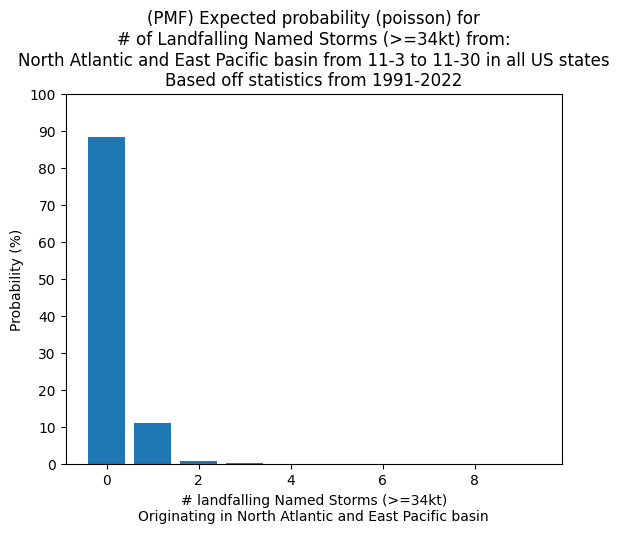

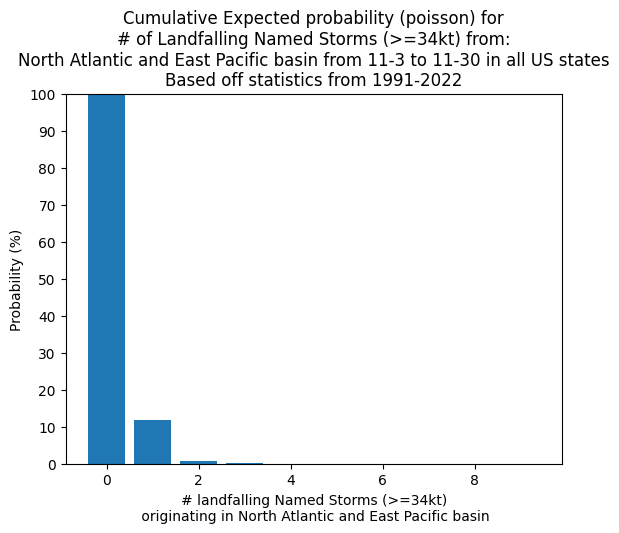

In [23]:
##### COMBINED NA AND EP BASIN STATISTICS FOR US LANDFALLS FOR NAMED STORMS (>= 34kt)
# set optionally either to None (default 1991-2022)
start_year = 1991
end_year = 2022
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 11
start_day = 3
end_month = 11
end_day = 30
# either None, or a list of 2 letter states to include
states = None
#states = ['NY', 'NJ']

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'

states_str = 'in '
if states:
    states_str += ','.join(states)
else:
    states_str += 'all US states'

full_basin_name = "North Atlantic and East Pacific"

df_ref_with_state = dfs_na_ep_us_landfalls['ts_ss_hu'].copy(deep=True)
    
# with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
df_unique_storms = df_unique_storms.reset_index(drop=True)
print(f"# US Named Storm landfalls (>=34 kt) in records from {full_basin_name} basins:", len(df_unique_storms))

landfalling_in_period = get_landfalling_conditional(
    df_ref_with_state,
    states=states,
    start_year=start_year, end_year=end_year,
    start_month_num=start_month, start_day_num_of_month=start_day,
    end_month_num=end_month, end_day_num_of_month=end_day
)
#print(landfalling_in_period)
num_years = (end_year - start_year + 1)
num_in_period = len(landfalling_in_period)
print(f"# US Named Storm landfalls (>=34 kt) from {full_basin_name} basins, {start_year} to {end_year} {sub_period_str} {states_str}:", num_in_period)

event_counts = list(range(0,10))
pmf_pct_per_event_count = []
cum_pct_per_event_count = []
pct_total = 0
for n in event_counts:
    pct = 100 * poisson_pmf(num_years, num_in_period, n)
    pct_total += pct
    pmf_pct_per_event_count.append(pct)

remaining_pct = pct_total
# get cumulative probability from pmf
for pct in pmf_pct_per_event_count:
    cum_pct_per_event_count.append(remaining_pct)
    remaining_pct = remaining_pct - pct

print("PMF % (starting from 0):", pmf_pct_per_event_count)
print("Cumulative % (starting from 0):", cum_pct_per_event_count)

# Create a bar chart
plt.bar(event_counts, pmf_pct_per_event_count)

plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))

# Label the axes and give the chart a title
plt.xlabel(f'# landfalling Named Storms (>=34kt)\nOriginating in {full_basin_name} basin')
plt.ylabel('Probability (%)')
plt.title(f"(PMF) Expected probability (poisson) for\n# of Landfalling Named Storms (>=34kt) from:\n" +
          f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
          f"Based off statistics from {start_year}-{end_year}")

# Show the chart
plt.show()

# Cumulative Probabilities chart
plt.bar(event_counts, cum_pct_per_event_count)

plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))

# Label the axes and give the chart a title
plt.xlabel(f'# landfalling Named Storms (>=34kt)\n originating in {full_basin_name} basin')
plt.ylabel('Probability (%)')
plt.title(f"Cumulative Expected probability (poisson) for\n# of Landfalling Named Storms (>=34kt) from:\n" +
          f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
          f"Based off statistics from {start_year}-{end_year}")
plt.show()

# US Tropical/Subtropical Storm landfalls in records from East Pacific basin: 2
# US Tropical/Subtropical Storm landfalls from East Pacific basin, 1991 to 2022 from 11-1 to 11-30 in all US states: 0
PMF % (starting from 0): [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Cumulative % (starting from 0): [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


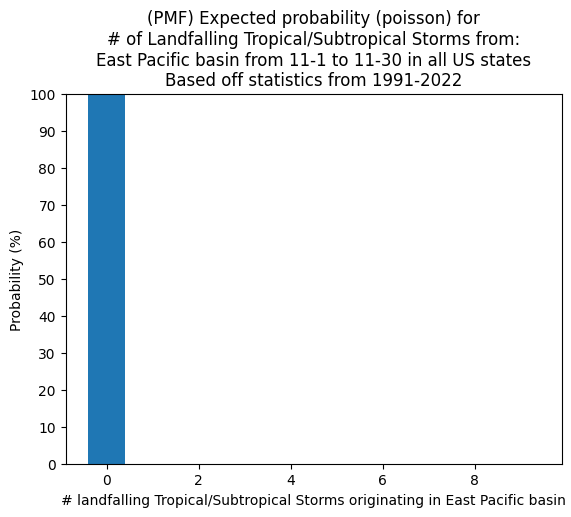

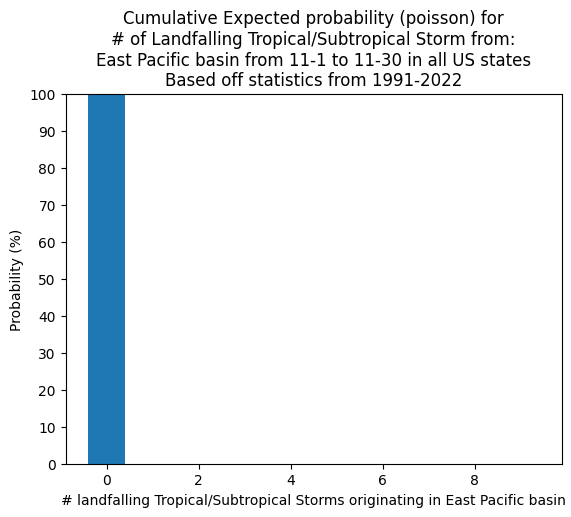

# US Hurricane landfalls in records from East Pacific basin: 4
# US Hurricane landfalls from East Pacific basin, 1991 to 2022 from 11-1 to 11-30 in all US states: 0
PMF % (starting from 0): [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Cumulative % (starting from 0): [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


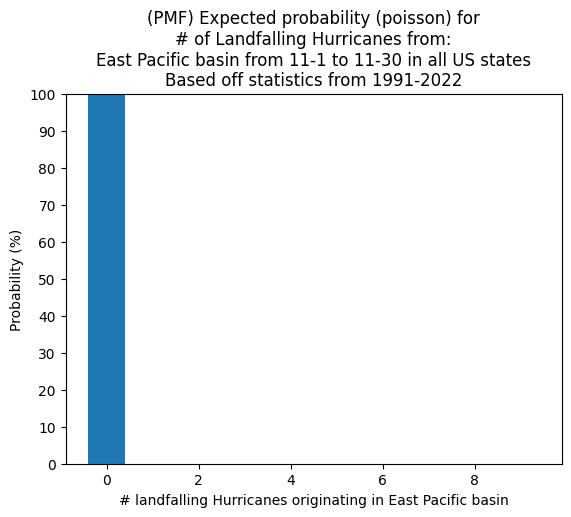

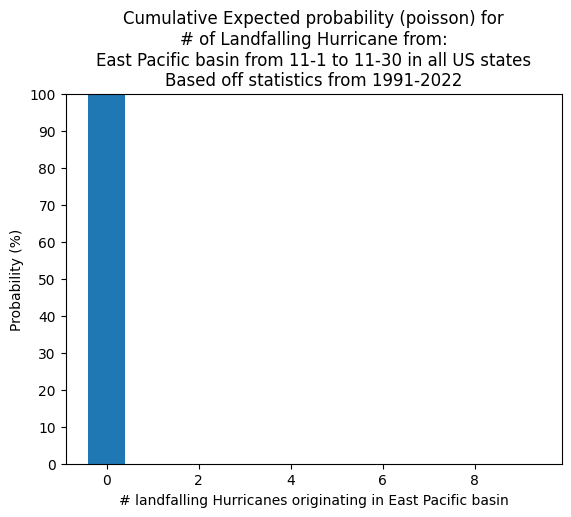

# US Tropical/Subtropical Storm landfalls in records from North Atlantic basin: 273
# US Tropical/Subtropical Storm landfalls from North Atlantic basin, 1991 to 2022 from 11-1 to 11-30 in all US states: 4
PMF % (starting from 0): [88.24969025845954, 11.031211282307442, 0.6894507051442151, 0.0287271127143423, 0.0008977222723231969, 2.2443056808079923e-05, 4.6756368350166506e-07, 8.34935149110116e-09, 1.3045861704845562e-10, 1.811925236784106e-12]
Cumulative % (starting from 0): [99.99999999999996, 11.75030974154042, 0.7190984592329777, 0.029647754088762523, 0.0009206413744202238, 2.2919102097026947e-05, 4.760452889470245e-07, 8.481605445359421e-09, 1.3225395425826112e-10, 1.7953372098054954e-12]


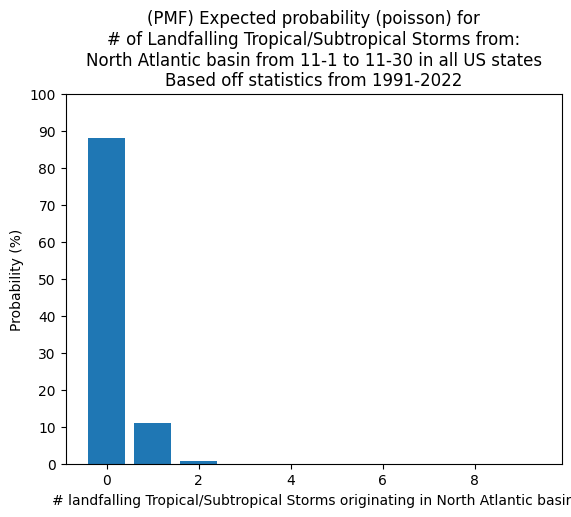

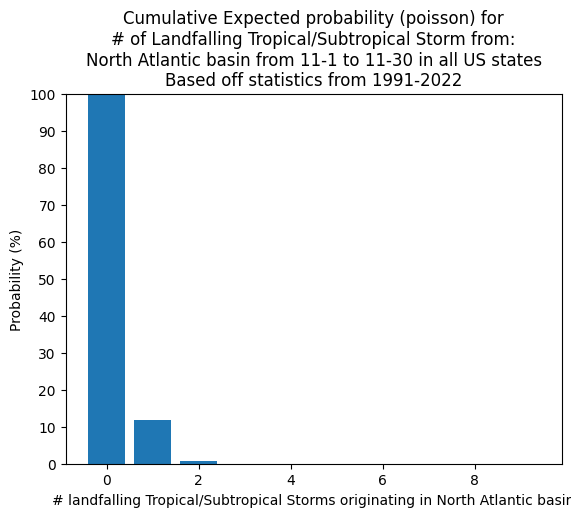

# US Hurricane landfalls in records from North Atlantic basin: 272
# US Hurricane landfalls from North Atlantic basin, 1991 to 2022 from 11-1 to 11-30 in all US states: 1
PMF % (starting from 0): [96.9233234476344, 3.028853857738575, 0.047325841527165236, 0.0004929775159079712, 3.851386843031025e-06, 2.4071167768943906e-08, 1.2537066546324952e-10, 5.596904708180781e-13, 2.1862909016331177e-15, 7.59128785289277e-18]
Cumulative % (starting from 0): [99.99999999999997, 3.0766765523655693, 0.04782269462699418, 0.0004968530998289422, 3.87558392097101e-06, 2.4197077939984652e-08, 1.25910171040746e-10, 5.395055774964782e-13, -2.0184893321599928e-14, -2.2371184223233047e-14]


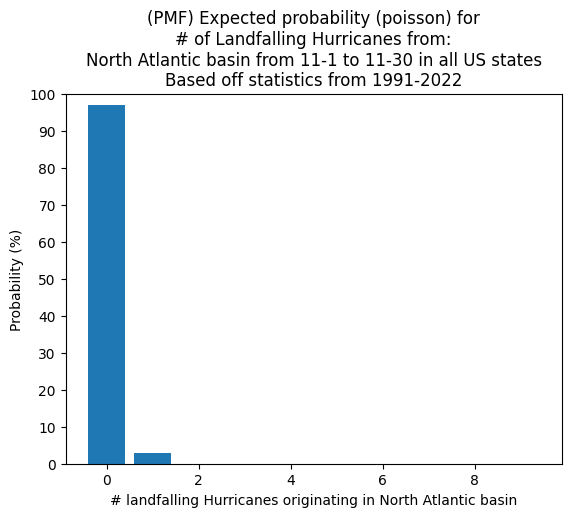

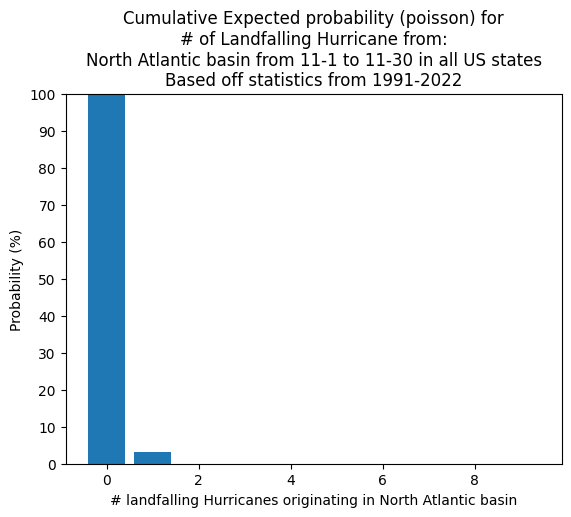

In [18]:
##### BY BASIN STATISTICS FOR US LANDFALLS
# set optionally either to None (default 1991-2022)
start_year = 1991
end_year = 2022
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 11
start_day = 1
end_month = 11
end_day = 30
# either None, or a list of 2 letter states to include
states = None
#states = ['NJ', 'NY']

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'
    
states_str = 'in '
if states:
    states_str += ','.join(states)
else:
    states_str += 'all US states'
    
for basin_name, dict_dfs in dfs_by_basin.items():
    storm_types = {'TS/SS': 'Tropical/Subtropical Storm', 'HU': "Hurricane"}
    storm_type_short_to_dict_key_mapping = {'TS/SS': 'us_landfalls_ts_ss', 'HU': 'us_landfalls_hu'}
    basin_mapping = {'NA': 'North Atlantic', 'EP': 'East Pacific'}
    full_basin_name = basin_mapping[basin_name]    
    for storm_type_short, storm_type_long in storm_types.items():
        df_ref_with_state = dict_dfs[storm_type_short_to_dict_key_mapping[storm_type_short]].copy(deep=True)
        # with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
        df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
        df_unique_storms = df_unique_storms.reset_index(drop=True)
        print(f"# US {storm_type_long} landfalls in records from {full_basin_name} basin:", len(df_unique_storms))
        
        landfalling_in_period = get_landfalling_conditional(
            df_ref_with_state,
            states=states,
            start_year=start_year, end_year=end_year,
            start_month_num=start_month, start_day_num_of_month=start_day,
            end_month_num=end_month, end_day_num_of_month=end_day
        )

        num_years = (end_year - start_year + 1)
        num_in_period = len(landfalling_in_period)
        print(f"# US {storm_type_long} landfalls from {full_basin_name} basin, {start_year} to {end_year} {sub_period_str} {states_str}:", num_in_period)

        event_counts = list(range(0,10))
        pmf_pct_per_event_count = []
        cum_pct_per_event_count = []
        pct_total = 0
        for n in event_counts:
            pct = 100 * poisson_pmf(num_years, num_in_period, n)
            pct_total += pct
            pmf_pct_per_event_count.append(pct)

        remaining_pct = pct_total
        # get cumulative probability from pmf
        for pct in pmf_pct_per_event_count:
            cum_pct_per_event_count.append(remaining_pct)
            remaining_pct = remaining_pct - pct
        
        print("PMF % (starting from 0):", pmf_pct_per_event_count)
        print("Cumulative % (starting from 0):", cum_pct_per_event_count)
        # Create a bar chart
        # PMF
        plt.bar(event_counts, pmf_pct_per_event_count)
        
        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# landfalling {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"(PMF) Expected probability (poisson) for\n# of Landfalling {storm_type_long}s from:\n" +
                  f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")

        # Show the chart
        plt.show()
        
        # Cumulative Probabilities chart
        plt.bar(event_counts, cum_pct_per_event_count)

        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# landfalling {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"Cumulative Expected probability (poisson) for\n# of Landfalling {storm_type_long} from:\n" +
                  f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")
        plt.show()

In [ ]:
##### COMBINED NA AND EP BASIN STATISTICS FOR US LANDFALLS
# set optionally either to None (default 1991-2022)
start_year = 1991
end_year = 2022
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 10
start_day = 25
end_month = 11
end_day = 30
# either None, or a list of 2 letter states to include
states = None
#states = ['NY', 'NJ']

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'
    
states_str = 'in '
if states:
    states_str += ','.join(states)
else:
    states_str += 'all US states'

full_basin_name = "North Atlantic and East Pacific"

storm_types = {'TS/SS': 'Tropical/Subtropical Storms (>=34 kt)', 'HU': "Hurricanes", 'TS/SS/HU': 'Named Storms (>=34 kt)'}
storm_type_short_to_dict_key_mapping = {'TS/SS': 'ts_ss', 'HU': 'hu', 'TS/SS/HU': 'ts_ss_hu'}
for storm_type_short, storm_type_long in storm_types.items():
    k = storm_type_short_to_dict_key_mapping[storm_type_short]
    df_ref_with_state = dfs_na_ep_us_landfalls[k].copy(deep=True)
    # with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
    df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
    df_unique_storms = df_unique_storms.reset_index(drop=True)
    print(f"# US {storm_type_long} landfalls in records from {full_basin_name} basins:", len(df_unique_storms))

    landfalling_in_period = get_landfalling_conditional(
        df_ref_with_state,
        states=states,
        start_year=start_year, end_year=end_year,
        start_month_num=start_month, start_day_num_of_month=start_day,
        end_month_num=end_month, end_day_num_of_month=end_day
    )
    
    num_years = (end_year - start_year + 1)
    num_in_period = len(landfalling_in_period)
    print(f"# US {storm_type_long} landfalls from {full_basin_name} basins, {start_year} to {end_year} {sub_period_str} {states_str}:", num_in_period)

    event_counts = list(range(0,10))
    pmf_pct_per_event_count = []
    cum_pct_per_event_count = []
    pct_total = 0
    for n in event_counts:
        pct = 100 * poisson_pmf(num_years, num_in_period, n)
        pct_total += pct
        pmf_pct_per_event_count.append(pct)
            
    remaining_pct = pct_total
    # get cumulative probability from pmf
    for pct in pmf_pct_per_event_count:
        cum_pct_per_event_count.append(remaining_pct)
        remaining_pct = remaining_pct - pct

    print("PMF % (starting from 0):", pmf_pct_per_event_count)
    print("Cumulative % (starting from 0):", cum_pct_per_event_count)
    # Create a bar chart
    # PMF
    plt.bar(event_counts, pmf_pct_per_event_count)

    plt.ylim(0, 100)
    plt.yticks(range(0, 101, 10))

    # Label the axes and give the chart a title
    plt.xlabel(f'# landfalling {storm_type_long}\nOriginating in {full_basin_name} basin')
    plt.ylabel('Probability (%)')
    plt.title(f"(PMF) Expected probability (poisson) for\n# of Landfalling {storm_type_long} from:\n" +
              f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
              f"Based off statistics from {start_year}-{end_year}")

    # Show the chart
    plt.show()

    # Cumulative Probabilities chart
    plt.bar(event_counts, cum_pct_per_event_count)

    plt.ylim(0, 100)
    plt.yticks(range(0, 101, 10))

    # Label the axes and give the chart a title
    plt.xlabel(f'# {storm_type_long}s originating in {full_basin_name} basin')
    plt.ylabel('Probability (%)')
    plt.title(f"Cumulative Expected probability (poisson) for\n# of Landfalling {storm_type_long} from:\n" +
              f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
              f"Based off statistics from {start_year}-{end_year}")
    plt.show()

# US Tropical/Subtropical Storm in records from East Pacific basin: 1175
# US Tropical/Subtropical Storm from East Pacific basin, 1991 to 2022 from 10-25 to 11-30: 29
PMF % (starting from 0): [40.403652366334214, 36.61580995699038, 16.591538886761263, 5.012027372042466, 1.1355374514783712, 0.20581616308045478, 0.03108681629861036, 0.0040246324672308055, 0.0004559153966784897, 4.590814758220902e-05, 4.160425874637693e-06, 3.4276235899003716e-07, 2.5885698986226765e-08, 1.8045319004821542e-09, 1.1681121677228233e-10, 7.057344346658723e-12, 3.9973239463496675e-13, 2.1309263684584626e-14, 1.0728622341197121e-15, 5.117270524584154e-17, 2.3187632064521942e-18, 1.0006567408796671e-19, 4.122023506464539e-21, 1.62416687075369e-22, 6.132921777585549e-24, 2.2231841443747613e-25, 7.749079349383182e-27, 2.600964133473522e-28, 8.41829909271564e-30, 2.6307184664736382e-31]
Cumulative % (starting from 0): [100.00000000000004, 59.59634763366583, 22.980537676675446, 6.388998789914183, 1.376971417871717,

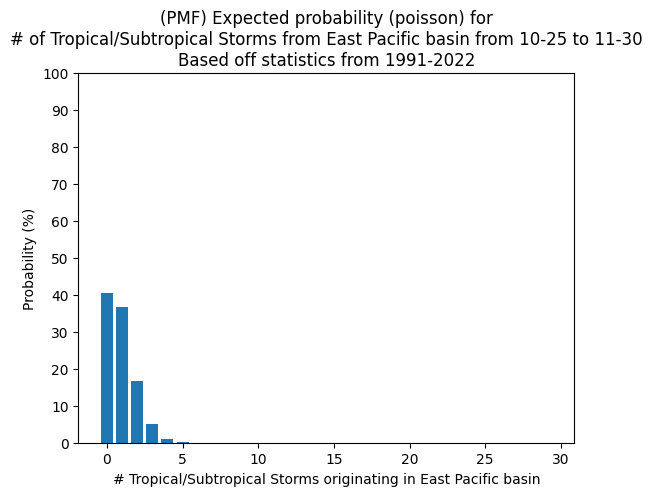

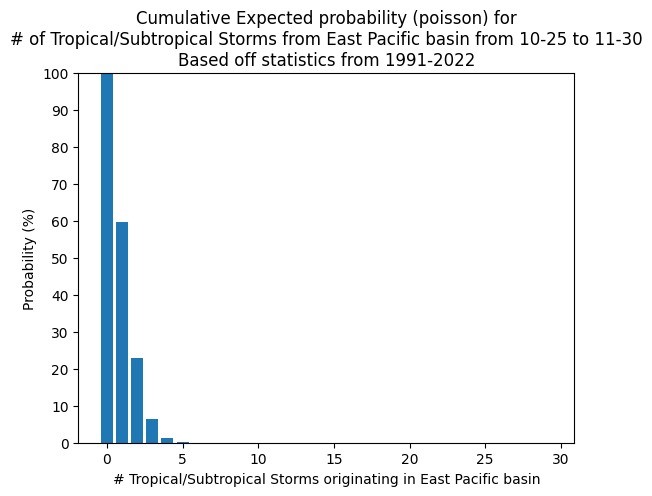

# US Hurricane in records from East Pacific basin: 598
# US Hurricane from East Pacific basin, 1991 to 2022 from 10-25 to 11-30: 9
PMF % (starting from 0): [75.48396019890073, 21.229863805940834, 2.9854495977104296, 0.27988589978535283, 0.01967947732865762, 0.0011069705997369908, 5.188924686267145e-05, 2.0848358114466205e-06, 7.329500899617026e-08, 2.290469031130321e-09, 6.441944150054026e-11, 1.6470879929115412e-12, 3.8603624833864244e-14, 8.3517457573264e-16, 1.6778060673200356e-17, 3.1458863762250664e-19, 5.529878395708124e-21, 9.148695875252412e-23, 1.4294837305081894e-24, 2.1160121010812016e-26, 2.9756420171454396e-28, 3.985234844391214e-30, 5.094760454477403e-32, 6.230005990529434e-34, 7.300788270151682e-36, 8.21338680392064e-38, 8.884673225394922e-40, 9.254867943119713e-42, 9.296184317865782e-44, 9.015695997930176e-46]
Cumulative % (starting from 0): [100.0, 24.516039801099268, 3.286175995158434, 0.30072639744800433, 0.020840497662651503, 0.0011610203339938834, 5.404973425689251

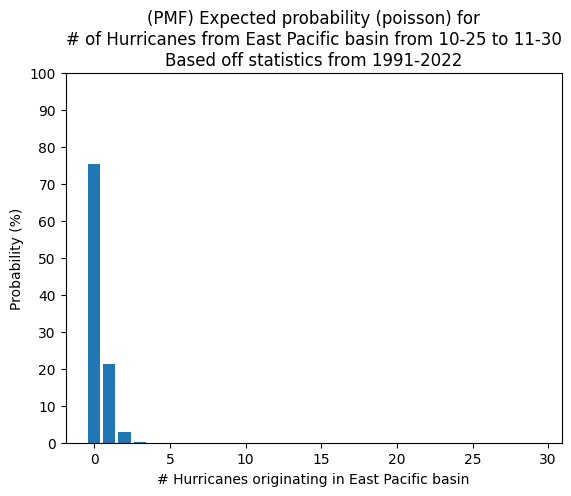

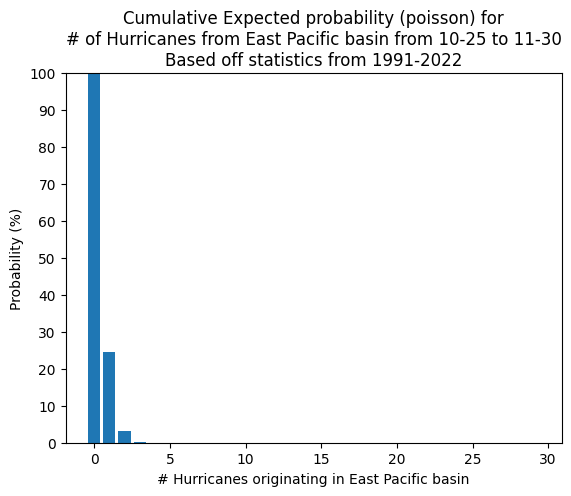

# US Named Storm in records from East Pacific basin: 1216
# US Named Storm from East Pacific basin, 1991 to 2022 from 10-25 to 11-30: 29
PMF % (starting from 0): [40.403652366334214, 36.61580995699038, 16.591538886761263, 5.012027372042466, 1.1355374514783712, 0.20581616308045478, 0.03108681629861036, 0.0040246324672308055, 0.0004559153966784897, 4.590814758220902e-05, 4.160425874637693e-06, 3.4276235899003716e-07, 2.5885698986226765e-08, 1.8045319004821542e-09, 1.1681121677228233e-10, 7.057344346658723e-12, 3.9973239463496675e-13, 2.1309263684584626e-14, 1.0728622341197121e-15, 5.117270524584154e-17, 2.3187632064521942e-18, 1.0006567408796671e-19, 4.122023506464539e-21, 1.62416687075369e-22, 6.132921777585549e-24, 2.2231841443747613e-25, 7.749079349383182e-27, 2.600964133473522e-28, 8.41829909271564e-30, 2.6307184664736382e-31]
Cumulative % (starting from 0): [100.00000000000004, 59.59634763366583, 22.980537676675446, 6.388998789914183, 1.376971417871717, 0.2414339663933458, 0.0356178

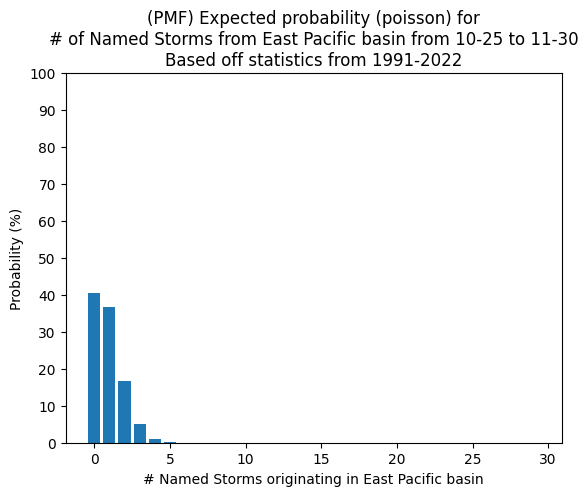

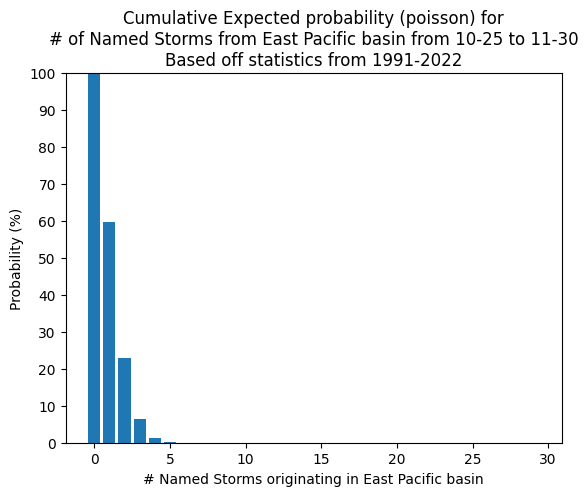

# US Tropical/Subtropical Storm in records from North Atlantic basin: 1689
# US Tropical/Subtropical Storm from North Atlantic basin, 1991 to 2022 from 10-25 to 11-30: 44
PMF % (starting from 0): [25.283959580474647, 34.765444423152644, 23.90124304091744, 10.954736393753826, 3.765690635352878, 1.0355649247220413, 0.2373169619154678, 0.04661583180482404, 0.008012096091454132, 0.0012240702361943812, 0.00016830965747672742, 2.1038707184590927e-05, 2.4106851982343773e-06, 2.5497631904402063e-07, 2.504231704896631e-08, 2.295545729488579e-09, 1.9727346112792476e-10, 1.5955941708876264e-11, 1.2188566583169367e-12, 8.82067318518836e-14, 6.064212814816998e-15, 3.970615533511129e-16, 2.4816347084444555e-17, 1.4835859670048375e-18, 8.499711269298548e-20, 4.6748411981142016e-21, 2.4722717874642413e-22, 1.2590272991716042e-23, 6.182723344146271e-25, 2.9314636545521117e-26]
Cumulative % (starting from 0): [99.99999999999999, 74.71604041952534, 39.9505959963727, 16.04935295545526, 5.094616561701432, 

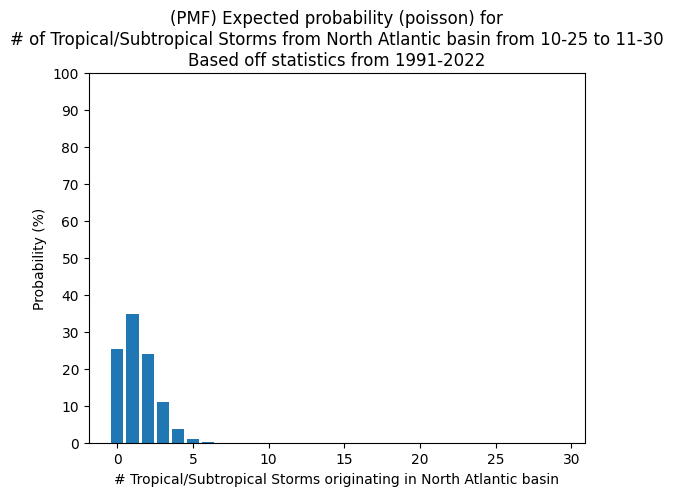

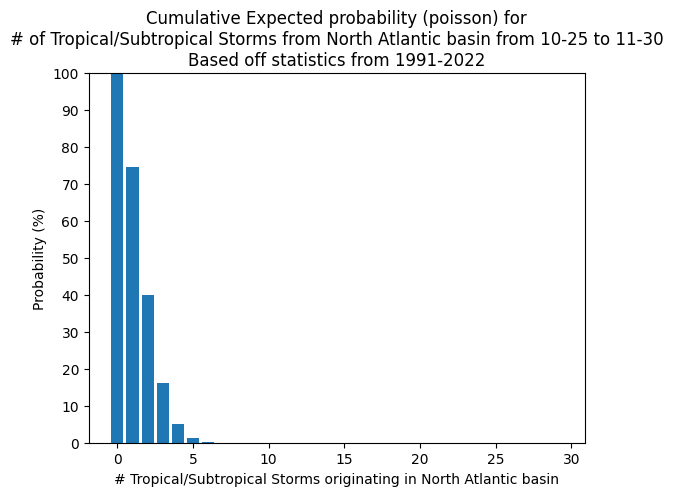

# US Hurricane in records from North Atlantic basin: 963
# US Hurricane from North Atlantic basin, 1991 to 2022 from 10-25 to 11-30: 27
PMF % (starting from 0): [43.009464064006224, 36.28923530400525, 15.309521143877216, 4.305802821715467, 0.9082552827056063, 0.15326807895657107, 0.021553323603267806, 0.00259794525575103, 0.00027400203869249145, 2.5687691127421074e-05, 2.167398938876153e-06, 1.6624935042515947e-07, 1.1689407451769026e-08, 7.586875028792396e-10, 4.572447003959704e-11, 2.5720014397273332e-12, 1.356328884231211e-13, 6.731779388647554e-15, 3.155521588428541e-16, 1.4013007053876743e-17, 5.911737350854251e-19, 2.3752516141825118e-20, 9.109629770302248e-22, 3.3418478776923996e-23, 1.1748683945012344e-24, 3.9651808314416667e-26, 1.2867774332803484e-27, 4.021179479001089e-29, 1.2117393519311316e-30, 3.525534752385836e-32]
Cumulative % (starting from 0): [100.00000000000003, 56.990535935993805, 20.701300631988552, 5.391779488111336, 1.0859766663958688, 0.17772138369026247, 0.024

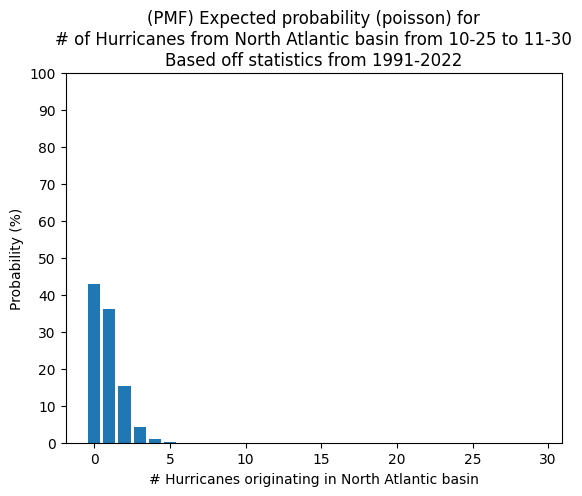

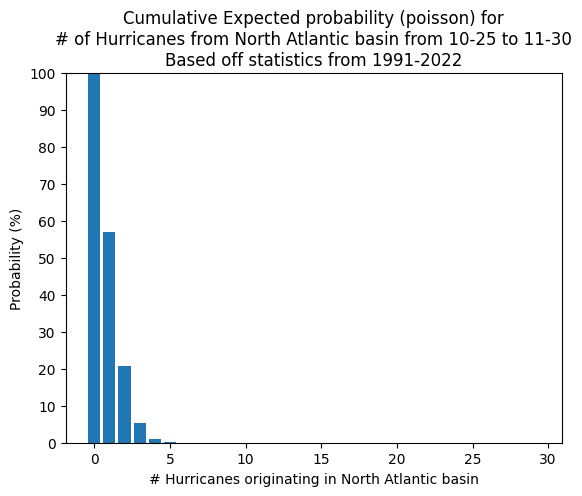

# US Named Storm in records from North Atlantic basin: 1741
# US Named Storm from North Atlantic basin, 1991 to 2022 from 10-25 to 11-30: 44
PMF % (starting from 0): [25.283959580474647, 34.765444423152644, 23.90124304091744, 10.954736393753826, 3.765690635352878, 1.0355649247220413, 0.2373169619154678, 0.04661583180482404, 0.008012096091454132, 0.0012240702361943812, 0.00016830965747672742, 2.1038707184590927e-05, 2.4106851982343773e-06, 2.5497631904402063e-07, 2.504231704896631e-08, 2.295545729488579e-09, 1.9727346112792476e-10, 1.5955941708876264e-11, 1.2188566583169367e-12, 8.82067318518836e-14, 6.064212814816998e-15, 3.970615533511129e-16, 2.4816347084444555e-17, 1.4835859670048375e-18, 8.499711269298548e-20, 4.6748411981142016e-21, 2.4722717874642413e-22, 1.2590272991716042e-23, 6.182723344146271e-25, 2.9314636545521117e-26]
Cumulative % (starting from 0): [99.99999999999999, 74.71604041952534, 39.9505959963727, 16.04935295545526, 5.094616561701432, 1.3289259263485542, 0.29336100

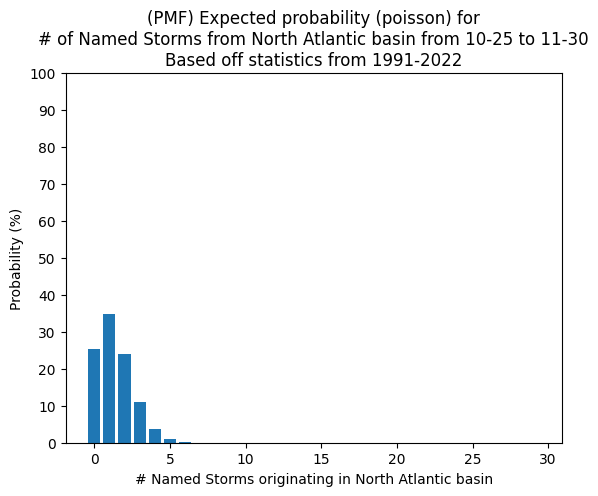

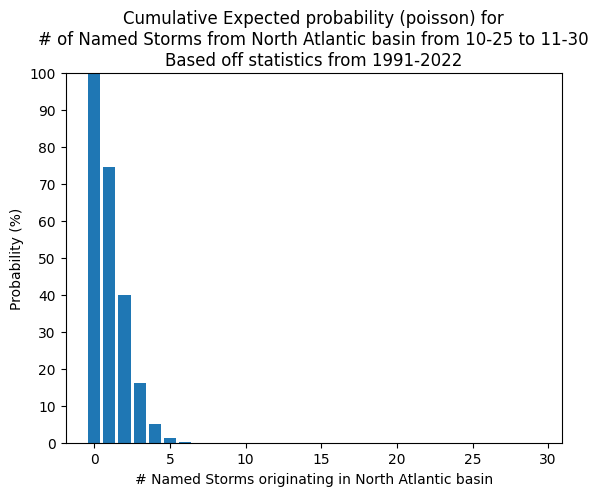

In [19]:
##### BY BASIN STATISTICS FOR STORM TYPES
# Currently, this only counts storms originating in NA basin,
#   and doesn't consider whether the storm crosses basins or which basin it strengthens in
#  Also, this only counts when the storm is at that intensity classification,
#    not necessarily when it first becomes that strength,
#    that is, it doesn't consider genesis of TS or strengthening into a hurricane timeframes,
#    just that the storm was classified such in the time frame
# set optionally either to None (default 1991-2022)
start_year = 1991
end_year = 2022
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 10
start_day = 25
end_month = 11
end_day = 30
# don't condition on states/landfall (don't check states)
states=None

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'

for basin_name, dict_dfs in dfs_by_basin.items():
    storm_types = {'TS/SS': 'Tropical/Subtropical Storm', 'HU': "Hurricane", "NAMED": "Named Storm"}
    storm_type_short_to_dict_key_mapping = {'TS/SS': 'ts_ss', 'HU': 'hu', 'NAMED': 'ts_ss_hu'}
    basin_mapping = {'NA': 'North Atlantic', 'EP': 'East Pacific'}
    full_basin_name = basin_mapping[basin_name]
    for storm_type_short, storm_type_long in storm_types.items():
        df_ref_with_state = dict_dfs[storm_type_short_to_dict_key_mapping[storm_type_short]].copy(deep=True)
        # with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
        df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
        df_unique_storms = df_unique_storms.reset_index(drop=True)
        print(f"# US {storm_type_long} in records from {full_basin_name} basin:", len(df_unique_storms))
        
        storms_in_period = get_landfalling_conditional(
            df_ref_with_state,
            states=states,
            start_year=start_year, end_year=end_year,
            start_month_num=start_month, start_day_num_of_month=start_day,
            end_month_num=end_month, end_day_num_of_month=end_day
        )
        num_years = (end_year - start_year + 1)
        num_in_period = len(storms_in_period)
        #for i in range(len(storms_in_period)):
        #    print(f"{storms_in_period.iloc[i]['SEASON']} : {storms_in_period.iloc[i]['USA_ATCF_ID']}")
        print(f"# US {storm_type_long} from {full_basin_name} basin, {start_year} to {end_year} {sub_period_str}:", num_in_period)

        event_counts = list(range(0,30))
        pmf_pct_per_event_count = []
        cum_pct_per_event_count = []
        pct_total = 0
        for n in event_counts:
            pct = 100 * poisson_pmf(num_years, num_in_period, n)
            pct_total += pct
            pmf_pct_per_event_count.append(pct)

        remaining_pct = pct_total
        # get cumulative probability from pmf
        for pct in pmf_pct_per_event_count:
            cum_pct_per_event_count.append(remaining_pct)
            remaining_pct = remaining_pct - pct

        print("PMF % (starting from 0):", pmf_pct_per_event_count)
        print("Cumulative % (starting from 0):", cum_pct_per_event_count)
        # Create a bar chart
        # PMF
        plt.bar(event_counts, pmf_pct_per_event_count)
        
        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"(PMF) Expected probability (poisson) for\n# of {storm_type_long}s from " +
                  f"{full_basin_name} basin {sub_period_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")
        
        # Show the chart
        plt.show()
        
        # Cumulative Probabilities chart
        plt.bar(event_counts, cum_pct_per_event_count)

        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"Cumulative Expected probability (poisson) for\n# of {storm_type_long}s from " +
                  f"{full_basin_name} basin {sub_period_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")

        
        # Show the chart
        plt.show()

In [20]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', 1000)

# Get Hurricanes that made landfall as Hurricanes by Intensity Category (Saffir-Simpson)
saffir_simpson = [
    (0, 63), # Verify there are no hurricanes that are hurricane status but still <= 63 kt
    (64, 82),
    (83, 95),
    (96, 112),
    (113, 136),
    (137, math.inf)
]
na_ep_us_landfall_hurricanes = dfs_na_ep_us_landfalls['hu'].copy(deep=True)
num_na_ep_us_landfall_hurricanes = len(na_ep_us_landfall_hurricanes.copy(deep=True).drop_duplicates(subset=['USA_ATCF_ID']))
num_na_ep_us_landfall_hurricanes_multiple_landfalls = len(na_ep_us_landfall_hurricanes.copy(deep=True))
print("Total hurricanes that made landfall in the US as a hurricane by category")
print("")
print(f"Total # hurricanes made landfall in US as hurricanes (counting only 1 landfall per storm): {num_na_ep_us_landfall_hurricanes}")
print(f"Total # landfalls in US of storms as hurricanes (counting multiple landfalls per storm): {num_na_ep_us_landfall_hurricanes_multiple_landfalls}")
num_unique_hurricanes_by_cat = {}
for cat_num, cat_range in enumerate(saffir_simpson):
    cat_lower = cat_range[0]
    cat_higher = cat_range[1]
    hurricane_landfalls_in_cat_range = na_ep_us_landfall_hurricanes.loc[
        (na_ep_us_landfall_hurricanes['USA_WIND'] >= cat_lower) &
        (na_ep_us_landfall_hurricanes['USA_WIND'] <= cat_higher)
    ]
    unique_hurricanes_in_cat = hurricane_landfalls_in_cat_range.drop_duplicates(subset=['USA_ATCF_ID'])
    unique_hurricanes_in_cat = unique_hurricanes_in_cat.reset_index(drop=True)
    num_unique_hurricanes_in_cat = len(unique_hurricanes_in_cat)
    # sanity check of data
    if cat_num == 0:
        if num_unique_hurricanes_in_cat == 0:
            continue
        else:
            # this line should never be reached
            print("Error: found storms with hurricane status at landfall not having hurricane intensity")
    
    num_unique_hurricanes_by_cat[cat_num] = num_unique_hurricanes_in_cat
    
    # start index at 1
    unique_hurricanes_in_cat.index += 1
    print("")
    print("")
    print("")
    print("=====================================================================")
    print(f"# Category {cat_num} Hurricanes at US Landfall: {num_unique_hurricanes_in_cat}")
    print("=====================================================================")
    print(f"Select statistics from Category {cat_num} Hurricanes at US Landfall:")
    print("")
    print(unique_hurricanes_in_cat[['SEASON', 'NAME', 'USA_ATCF_ID', 'ISO_TIME', 'LAT', 'LON', 'USA_WIND', 'LANDFALL_STATE']])
#dfs_na_ep_us_landfalls['hu'].loc[dfs_na_ep_us_landfalls['hu']['USA_WIND'] >= 137]

print("")
print("")
print("")
print("===========================================================================")
print("Summary of Landfalling Hurricanes by Category (# unique storms per category)")
print("  * Some may have landfalled in more than one category")
print("============================================================================")
print("")
print("Category #: # Hurricanes")
print("========================")
for cat_num, num_unique_hurricanes_in_cat in num_unique_hurricanes_by_cat.items():
    print(f"Category {cat_num}: {num_unique_hurricanes_in_cat}")


Total hurricanes that made landfall in the US as a hurricane by category

Total # hurricanes made landfall in US as hurricanes (counting only 1 landfall per storm): 273
Total # landfalls in US of storms as hurricanes (counting multiple landfalls per storm): 311



# Category 1 Hurricanes at US Landfall: 122
Select statistics from Category 1 Hurricanes at US Landfall:

     SEASON       NAME USA_ATCF_ID            ISO_TIME      LAT      LON  USA_WIND LANDFALL_STATE
1      1851  NOT_NAMED    AL011851 1851-06-25 21:00:00  28.1333 -96.5667      80.0             TX
2      1852  NOT_NAMED    AL031852 1852-09-12 00:00:00  27.9333 -82.8000      70.0             FL
3      1854  NOT_NAMED    AL011854 1854-06-26 12:00:00  26.1667 -97.0667      70.0             TX
4      1858  NOT_NAMED    AL031858 1858-09-16 17:00:00  41.1181 -71.9064      80.0             NY
5      1859  NOT_NAMED    AL051859 1859-09-16 00:00:00  30.6000 -87.8333      70.0             AL
6      1859  NOT_NAMED    AL081859 1859-1

In [21]:
#https://manifold.markets/AndrewG/how-many-named-storms-will-there-be-69926f0b906d
# 80% of Tammy forming in 7 days
next_storm_genesis_prob = 1
import numpy as np
x = [25.283959580474647, 34.765444423152644, 23.90124304091744, 10.954736393753826, 3.765690635352878, 1.0355649247220413, 0.2373169619154678, 0.04661583180482404, 0.008012096091454132, 0.0012240702361943812, 0.00016830965747672742, 2.1038707184590927e-05, 2.4106851982343773e-06, 2.5497631904402063e-07, 2.504231704896631e-08, 2.295545729488579e-09, 1.9727346112792476e-10, 1.5955941708876264e-11, 1.2188566583169367e-12, 8.82067318518836e-14, 6.064212814816998e-15, 3.970615533511129e-16, 2.4816347084444555e-17, 1.4835859670048375e-18, 8.499711269298548e-20, 4.6748411981142016e-21, 2.4722717874642413e-22, 1.2590272991716042e-23, 6.182723344146271e-25, 2.9314636545521117e-26]
x0 = x[0] * (1 - next_storm_genesis_prob)
x1rest = x[1:]
new_total = x0 + np.sum(x1rest)
new_x = [np.divide(x0, 100)]
new_x.extend(np.divide(x1rest, new_total))
# 200 bet size
bet_size = 200
print(list(np.multiply(new_x, bet_size)))

[0.0, 93.06018956022587, 63.97888032265527, 29.323653481217, 10.080005884168344, 2.7720016181462945, 0.6352503708251924, 0.12478132284066282, 0.021446789863238922, 0.003276592895772613, 0.00045053152316873435, 5.6316440396091794e-05, 6.452925462052185e-06, 6.825209623324425e-07, 6.703330880050775e-08, 6.144719973379877e-09, 5.280618727123333e-10, 4.271088676349753e-11, 3.262637183322728e-12, 2.3611190142467116e-13, 1.6232693222946145e-14, 1.0628549134071877e-15, 6.642843208794923e-17, 3.9712649617795735e-18, 2.2752038843528808e-19, 1.2513621363940844e-20, 6.617780529007177e-22, 3.370166010142544e-23, 1.654992237123571e-24, 7.846945951879e-26]


In [22]:
#NS ATLANTIC
# for Oct 18th+
# [16.842748127818425, 30.001145102676567, 26.71976985707132, 15.864863352636096, 7.064821961720762, 2.5168428238630214, 0.7471877133343343, 0.19013258776811187, 0.04233420899524366, 0.00837864553030864, 0.0014924462350862267, 0.00024167453238612194, 3.587356340106497e-05, 4.915368062165153e-06, 6.253928114808342e-07, 7.426539636334905e-08, 8.26782732951347e-09, 8.662980841585803e-10, 8.572741457819285e-11, 8.03694511670558e-12, 7.157904244565908e-13, 6.071436636015725e-14, 4.91579386722864e-15, 3.807068620000442e-16, 2.8255587414065784e-17, 2.0132106032521867e-18, 1.379242841170368e-19, 9.09917152161007e-21, 5.788535454595691e-22, 3.555458199482267e-23]
# for Oct 25th
# [25.283959580474647, 34.765444423152644, 23.90124304091744, 10.954736393753826, 3.765690635352878, 1.0355649247220413, 0.2373169619154678, 0.04661583180482404, 0.008012096091454132, 0.0012240702361943812, 0.00016830965747672742, 2.1038707184590927e-05, 2.4106851982343773e-06, 2.5497631904402063e-07, 2.504231704896631e-08, 2.295545729488579e-09, 1.9727346112792476e-10, 1.5955941708876264e-11, 1.2188566583169367e-12, 8.82067318518836e-14, 6.064212814816998e-15, 3.970615533511129e-16, 2.4816347084444555e-17, 1.4835859670048375e-18, 8.499711269298548e-20, 4.6748411981142016e-21, 2.4722717874642413e-22, 1.2590272991716042e-23, 6.182723344146271e-25, 2.9314636545521117e-26]
print(list(np.multiply(2, [25.283959580474647, 34.765444423152644, 23.90124304091744, 10.954736393753826, 3.765690635352878, 1.0355649247220413, 0.2373169619154678, 0.04661583180482404, 0.008012096091454132, 0.0012240702361943812, 0.00016830965747672742, 2.1038707184590927e-05, 2.4106851982343773e-06, 2.5497631904402063e-07, 2.504231704896631e-08, 2.295545729488579e-09, 1.9727346112792476e-10, 1.5955941708876264e-11, 1.2188566583169367e-12, 8.82067318518836e-14, 6.064212814816998e-15, 3.970615533511129e-16, 2.4816347084444555e-17, 1.4835859670048375e-18, 8.499711269298548e-20, 4.6748411981142016e-21, 2.4722717874642413e-22, 1.2590272991716042e-23, 6.182723344146271e-25, 2.9314636545521117e-26])))

[50.567919160949295, 69.53088884630529, 47.80248608183488, 21.909472787507653, 7.531381270705756, 2.0711298494440826, 0.4746339238309356, 0.09323166360964807, 0.016024192182908265, 0.0024481404723887623, 0.00033661931495345483, 4.2077414369181854e-05, 4.821370396468755e-06, 5.099526380880413e-07, 5.008463409793262e-08, 4.591091458977158e-09, 3.945469222558495e-10, 3.191188341775253e-11, 2.4377133166338735e-12, 1.764134637037672e-13, 1.2128425629633996e-14, 7.941231067022258e-16, 4.963269416888911e-17, 2.967171934009675e-18, 1.6999422538597097e-19, 9.349682396228403e-21, 4.944543574928483e-22, 2.5180545983432085e-23, 1.2365446688292542e-24, 5.862927309104223e-26]
